In [11]:
import jax.numpy as np
from jax import random, jit, grad, vmap
from jax.experimental import optimizers
import jax.scipy.stats.norm as norm
from jax.scipy.stats import multivariate_normal
from tqdm import trange
from functools import partial
import matplotlib.pyplot as plt

In [12]:
## Helper functions for fitting a mean-field variational family to a target distribution
def sample_q(rng_key, params):
    mean, log_std = params
    return mean + np.exp(log_std) * random.normal(rng_key, mean.shape)

def eval_log_q(x, params):
    mean, log_std = params
    return np.log(multivariate_normal.pdf(x, mean, np.diag(np.exp(log_std))))

def per_example_KL(eval_log_p, params, rng_key):
    sample = sample_q(rng_key, params)
    return eval_log_q(sample, params) - eval_log_p(sample)

def KL_loss(eval_log_p, params, rng_key, num_mc_samples):
    # Average over a batch of random samples.
    rng_keyes = random.split(rng_key, num_mc_samples)
    pe_loss = lambda key: per_example_KL(eval_log_p, params, key)
    loss = vmap(pe_loss)(rng_keyes)
    return np.mean(loss)

In [13]:
# ========= Define an target density =========
def target_logpdf(x):
    mean = np.array([1.0, -0.6])
    cov = np.array([[0.68, 0.5],
                    [0.5, 0.68]])
    pdf = multivariate_normal.pdf(x, mean, cov)
    return np.log(pdf)

# def target_logpdf(x):
#     mean1 = np.array([1.0, -0.6])
#     cov1 = np.array([[0.68, 0.5],
#                     [0.5, 0.68]])
#     mean2 = np.array([-2.0, 0.5])
#     cov2 = np.array([[0.7, 0.3],
#                     [0.3, 0.7]])
#     pdf = multivariate_normal.pdf(x, mean1, cov1) + multivariate_normal.pdf(x, mean2, cov2)
#     return np.log(pdf)

In [14]:
# Initialize variational parameters and set up optimizer
D = 2
init_mean = np.zeros(D)
init_std  = np.zeros(D)
init_params = (init_mean, init_std)
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(init_params)

# Logger
loss_log = []

@jit
def objective(params, t, num_mc_samples = 50):
    rng_key = random.PRNGKey(t)
    return KL_loss(target_logpdf, params, rng_key, num_mc_samples)

@jit
def update(i, opt_state):
    params = get_params(opt_state)
    gradient = grad(objective)(params, i)
    return opt_update(i, gradient, opt_state)

In [15]:
# Main loop.
pbar = trange(5000)
for t in pbar:
    opt_state = update(t, opt_state)
    params = get_params(opt_state)
    loss_value = objective(params, t)
    loss_log.append(loss_value)
    pbar.set_postfix({'Loss': loss_value})

100%|██████████| 5000/5000 [00:16<00:00, 296.33it/s, Loss=0.13672733]


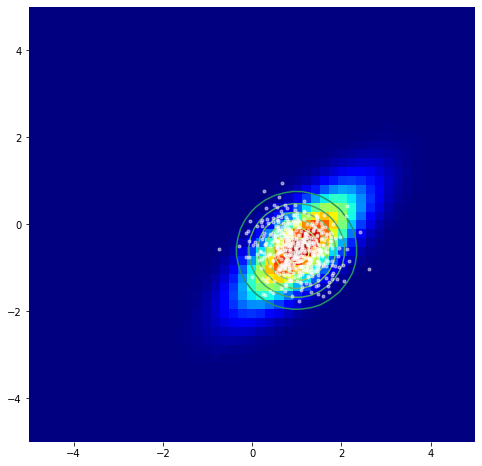

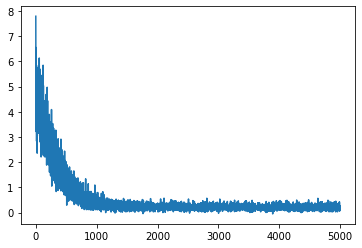

In [16]:
nn = 50
xx = np.linspace(-5, 5, nn)
yy = np.linspace(-5, 5, nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
target_dist = vmap(target_logpdf)(X_star)
target_dist_fn = lambda x: np.exp(target_logpdf(x))
approx_dist_fn = lambda x: np.exp(eval_log_q(x, params))

target_dist = vmap(target_dist_fn)(X_star).reshape(nn,nn)
approx_dist = vmap(approx_dist_fn)(X_star).reshape(nn,nn)


fig = plt.figure(figsize=(8,8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
ax.pcolor(XX, YY, target_dist, cmap='jet')
ax.contour(XX, YY, approx_dist, cmap='summer')
rng_keys = random.split(random.PRNGKey(t), 500)
samples = vmap(sample_q, in_axes=(0, None))(rng_keys, params)
ax.plot(samples[:, 0], samples[:, 1], 'w.', alpha=0.5)


plt.figure()
plt.plot(loss_log)
# plt.yscale('log')